In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root {--jp-notebook-max-width: 3000px;}</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

# 기계학습 (60점)

### 리그오브레전드 게임 로그 데이터
data_path = './data/game_result.csv'     
data_path = './data/log.csv'

데이터는 리그오브레전드 게임의 로그 데이터이다.    

---
리그오브 레전드 게임 룰
- 5명의 플레이어가 각자 다른 포지션에서 성장을 통해 아이템과 레벨을 올려 상대의 기지를 파괴하는 AOS장르의 게임
- 두 팀(red,blue)이 격돌, 각 팀은 5명의 플레이어가 5개의 포지션('T', 'J', 'M', 'B', 'S')을 하나씩 맡는다.   
---
데이터 설명
- game_result.csv : 게임 결과에 대한 정보
    - gameId: 게임명
    - win : 승리여부 True-승리, False-패배
    - TEAM: 팀 정보 (rea,blue)
    
- log.csv : 인게임 정보
    - time : 게임의 5분간격(~25분까지)
    - gameId : 게임명
    - variable : 6가지의 특정 행동 정보 
        - minionsKilled : 누적 몬스터 킬수
        - totalGold : 누적 골드획득량
        - totalDamageTaken : 누적 피해량
        - totalDamageDone : 누적 데미지
        - WARD_PLACED : 누적 시야 정보량
        - WARD_KILL : 누적 시야 제거량


In [1]:
import pandas as pd
gr =pd.read_csv('./data/game_result.csv')
display(gr.head())

log =pd.read_csv('./data/log.csv')
display(log.head())

,gameId,win,TEAM
0,JP1_340505476,False,blue
1,JP1_340505476,True,red
2,JP1_340611094,True,red
3,JP1_340611094,False,blue
4,JP1_340621330,True,red


,time,gameId,variable,value,POSITION,TEAM
0,5.0,LA1_1242504360,minionsKilled,33.0,T,blue
1,10.0,LA1_1242504360,minionsKilled,76.0,T,blue
2,15.0,LA1_1242504360,minionsKilled,110.0,T,blue
3,20.0,LA1_1242504360,minionsKilled,143.0,T,blue
4,25.0,LA1_1242504360,minionsKilled,167.0,T,blue


### 기계학습1
인게임 정보데이터는 5분간격의 누적 정보이다. each_variable 컬럼을 만들고 각 variable 별로 증가량값으로 채워넣어라      

<img src="./data/1.png" alt="alt_text" style="width:500px; float:left; ">

In [2]:
log['each_variable'] = log.groupby(['gameId','variable','POSITION','TEAM'])['value'].diff()
log['each_variable'] = log['each_variable'].combine_first(log['value'])

### 기계학습2
하나의 행에 하나의 인게임 정보를 넣는 작업을 하고 blue 팀의 승패유무와 관련한 데이터를 추가하려한다.     
아래의 전처리 조건을 확인하여 작업을 진행하라

변환할 데이터프레임의 컬럼정보
- gameId (게임아이디)
- {팀명}_{포지션}_{variable} 형식으로 컬럼을 추가한다. variable 별로 아래 조건을 만족하는 값을 채워 넣는다.
    - {팀명}_{포지션}_minionsKilled : 25분의 minionsKilled value컬럼 값을 추가한다.
    - {팀명}_{포지션}_totalGold : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageTaken : each_variable의 다섯 구간 평균값을 추가한다.
    - {팀명}_{포지션}_totalDamageDone : each_variable의 다섯 구간 분산값을 추가한다.
    - {팀명}_{포지션}_WARD_PLACED : 15분의 WARD_PLACED value컬럼 값을 추가한다.
    - {팀명}_{포지션}_WARD_KILL : each_variable의 max값을 추가한다.
- result : blue팀의 승리여부, 승리 : 1 , 패배 : 0 

아래와 같이 62개의 컬럼이 완성된다.    
<img src="./data/2.png" alt="alt_text" style="width:500px; float:left; ">

In [3]:
log['target'] = log['TEAM'] + '_' + log['POSITION'] + '_' + log['variable']

In [4]:
# minionsKilled
minionsKilled = log[(log.variable =='minionsKilled') & (log.time ==25)]
pivot_minionsKilled = minionsKilled.pivot_table(columns =['target'],values = 'value',index='gameId')


# totalGold 
totalGold = log[(log.variable =='totalGold')]
totalGold_group = totalGold.groupby(['target','gameId'])['each_variable'].mean().reset_index()
pivot_totalGold = totalGold_group.pivot_table(index='gameId',columns ='target',values='each_variable')

# totalDamageTaken 
totalDamageTaken = log[(log.variable =='totalDamageTaken')]
totalDamageTaken_group = totalDamageTaken.groupby(['target','gameId'])['each_variable'].mean().reset_index()
pivot_totalDamageTaken = totalDamageTaken_group.pivot_table(index='gameId',columns ='target',values='each_variable')


# totalDamageDone 
totalDamageDone = log[(log.variable =='totalDamageDone')]
totalDamageDone_group = totalDamageDone.groupby(['target','gameId'])['each_variable'].var().reset_index()
pivot_totalDamageDone = totalDamageDone_group.pivot_table(index='gameId',columns ='target',values='each_variable')


# WARD_PLACED 
WARD_PLACED = log[(log.variable =='WARD_PLACED') & (log.time ==15)]
pivot_WARD_PLACED = WARD_PLACED.pivot_table(columns =['target'],values = 'value',index='gameId')


# WARD_KILL 
WARD_KILL = log[(log.variable =='WARD_KILL')]
WARD_KILL_group = WARD_KILL.groupby(['gameId','target'])['each_variable'].max().reset_index()
pivot_WARD_KILL = WARD_KILL_group.pivot_table(index='gameId',columns='target',values = 'each_variable')

In [5]:
game_result = gr[gr.TEAM =='blue'].reset_index(drop=True)
game_result['result'] = game_result['win'].astype('int')
game_result = game_result.drop(columns =['win','TEAM'])
# game_result.set_index('gameId',inplace=True)

game_result = game_result.set_index('gameId')

In [6]:
t = pd.concat([pivot_minionsKilled,pivot_totalGold,pivot_totalDamageTaken,pivot_totalDamageDone,pivot_WARD_PLACED,pivot_WARD_KILL,game_result],axis=1).reset_index()

### 기계학습 3
데이터 EDA 및 시각화

In [11]:
t.iloc[:,1:].groupby(['result']).mean().T.sort_values(1)

result,0,1
red_T_WARD_KILL,1.393792e+00,1.276559e+00
red_M_WARD_KILL,1.537432e+00,1.369515e+00
blue_T_WARD_KILL,1.216068e+00,1.372979e+00
blue_M_WARD_KILL,1.315277e+00,1.545035e+00
red_B_WARD_KILL,1.774802e+00,1.612587e+00
blue_B_WARD_KILL,1.631163e+00,1.843533e+00
red_J_WARD_KILL,2.075472e+00,1.972286e+00
blue_J_WARD_KILL,2.055995e+00,2.026559e+00
red_S_WARD_KILL,2.790627e+00,2.571594e+00
blue_S_WARD_KILL,2.651856e+00,2.777136e+00


### 기계학습4      
전처리한 데이터를 바탕으로 승리 예측 분류 모델을 만들려고한다. 아래의 기준으로 모델링을 하고 평가를 진행하라     
- 랜덤포레스트와 그래디언트 부스팅으로 학습한다
- 각 모델별로 3개의 파라미터들을 2개 이상 조합하여 최적의 파라미터를 찾는다.   
- 학습데이터는 70%를 사용한다
- auc값으로 평가를 진행하며 ROC Curve를 그려라

In [20]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.metrics import auc ,roc_curve

from sklearn.preprocessing import StandardScaler


rf = RandomForestClassifier(random_state =1)
gbc = GradientBoostingClassifier(random_state=1)


rf_parameters = {'n_estimators':[50,100,200],'min_samples_split' : [2,3,4],'min_samples_leaf':[1,2,3]}
gbc_parameters = {'learning_rate':[0.1,0.01,0.001],'n_estimators':[50,100,200],'subsample' : [0.05,0.5,1]}


rf_clf = GridSearchCV(rf,rf_parameters)
gbc_clf = GridSearchCV(gbc,gbc_parameters)

x = t.drop(columns =['gameId','result'])
x_scaled = StandardScaler().fit_transform(x)

y = t['result']
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)


In [21]:
%%time
rf_clf.fit(X_train,y_train)

CPU times: user 2min 36s, sys: 1.31 s, total: 2min 38s
Wall time: 2min 39s


GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]})

In [22]:
%%time
gbc_clf.fit(X_train,y_train)

CPU times: user 4min 45s, sys: 1.89 s, total: 4min 47s
Wall time: 4min 48s


GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.05, 0.5, 1]})

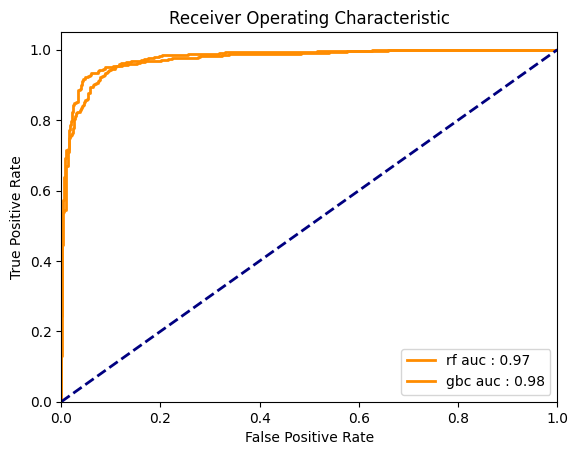

In [29]:
rf_predict = rf_clf.best_estimator_.predict_proba(X_test)[:,1]
gbc_predict = gbc_clf.best_estimator_.predict_proba(X_test)[:,1]


rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_predict)
rf_roc_auc = auc(rf_fpr, rf_tpr)


gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc_predict)
gbc_roc_auc = auc(gbc_fpr, gbc_tpr)

import matplotlib.pyplot as plt

# ROC 커브 그리기
plt.figure()
plt.plot(rf_fpr, rf_tpr, color='darkorange', lw=2, label=f'rf auc : {rf_roc_auc:.2f}')
plt.plot(gbc_fpr, gbc_tpr, color='darkorange', lw=2, label=f'gbc auc : {gbc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 기계학습5 
성능이 우수한 모델로부터 변수중요도를 시각화하고 해석하라

In [35]:
X_train

array([[ 0.27158776, -0.44436739,  0.13651142, ..., -0.40026529,
        -1.05055911, -0.21759369],
       [-0.73672268,  0.02496623, -0.26839194, ..., -1.28726157,
        -1.05055911, -0.86979501],
       [-0.43695471, -0.31921176,  0.8383439 , ...,  0.486731  ,
         0.82742659, -0.86979501],
       ...,
       [ 0.2988394 ,  0.3065664 ,  0.78435678, ..., -0.40026529,
         1.45342183, -0.21759369],
       [-0.81847758,  0.36914422, -0.56532106, ...,  0.486731  ,
        -0.42456388, -0.86979501],
       [ 0.05357469, -0.06890049,  0.649389  , ...,  0.486731  ,
        -1.05055911,  1.08680896]])

In [38]:
pm = pd.DataFrame()
pm['importance'] = gbc_clf.best_estimator_.feature_importances_
pm['feature_name'] = x.columns

In [40]:
pm.sort_values('importance',ascending=False)

,importance,feature_name
15,0.113412,red_B_totalGold
16,0.110684,red_J_totalGold
11,0.102027,blue_J_totalGold
19,0.080102,red_T_totalGold
18,0.077353,red_S_totalGold
13,0.076554,blue_S_totalGold
10,0.075982,blue_B_totalGold
14,0.075459,blue_T_totalGold
12,0.071934,blue_M_totalGold
17,0.059427,red_M_totalGold


### 폐처리 시설의 여러 대기 측정정보

data_path = './data/mc.csv'

데이터는 특정 폐수 처리시설 주변의 여러 측정센서를 통해 5분간격으로 측정한 데이터이다.
- 매 5분동안 최대 24개의 주변 측정소에서 여러 정보들을 수집한다. 

In [41]:
import pandas as pd
df = pd.read_csv('./data/mc.csv')
df.head()

,측정장소,측정일시,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
0,1,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
1,3,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,9.2,0.0,0.0,0,0.0,0.0
2,4,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.8,0.0,0.0,0,0.0,0.0
3,5,2022-01-10 09:00:00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.0,0.0
4,6,2022-01-10 09:00:00,12.14,81.9,0.3,0.03,6.0,0.0,0.0,0,1019.5,113.8


### 기계학습5    
다음의 기준으로 전처리를 시행하고 시각화를 포함한 EDA를 진행하라
1. 측정일시별로 측정장소 상관없이 각 측정값들의 최대값 1개만 남겨라. 
2. 1의 전처리 후 온도 ~ 초미세먼지 값이 모두 0인 데이터 행은 제거하라

In [56]:
g = df.groupby(['측정일시']).max().reset_index()
g['sum'] = g.iloc[:,2:].sum(axis=1)
g_filter = g[g['sum'] !=0].reset_index(drop=True).drop(columns =['측정장소','sum'])

In [58]:
g_filter.describe()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,강수량,기압,초미세먼지
count,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.000000,40364.0,40364.000000,40364.000000
mean,20.490898,61.882341,0.920166,0.266473,12.901856,36.746058,704.024581,0.0,922.426700,206.302254
std,4.507456,21.518572,0.270590,0.181363,5.876157,106.397281,1981.774919,0.0,298.034458,370.841189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,16.677500,50.530000,1.000000,0.140000,9.000000,5.000000,107.000000,0.0,1012.000000,17.000000
50%,20.330000,63.200000,1.000000,0.240000,14.400000,11.000000,174.700000,0.0,1017.700000,31.000000
75%,24.000000,78.170000,1.000000,0.370000,17.600000,24.000000,225.000000,0.0,1023.500000,65.000000
max,55.440000,100.000000,1.000000,1.400000,20.000000,1000.000000,18644.200000,0.0,1036.000000,985.000000


In [62]:
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

## https://wikidocs.net/45798

<AxesSubplot:>

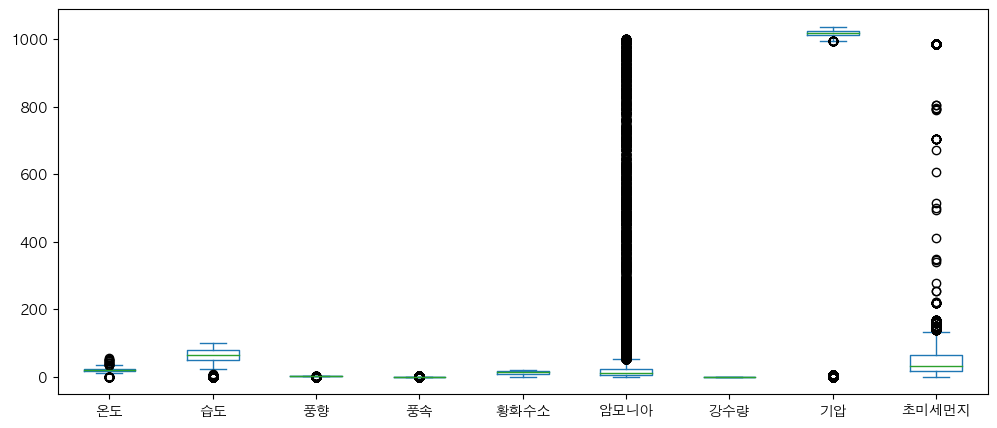

In [67]:
g_filter.drop(columns =['휘발성유기화합물']).iloc[:,1:].plot(kind='box',figsize=(12,5))

### 기계학습6     
데이터의 측정시간대를 일별 6시간 간격(0 ~ 5시 ,6~12시 ..)으로 나누어 각 컬럼의 수치 평균값을 내라. 
각 시간 구간을 0,1,2,3으로 표기하고 date_split 컬럼을 추가한다.

In [71]:
def split_hour(x):
    
    if x in range(0,6):
        return 0
    
    elif x in range(6,12):
        return 1
    
    elif x in range(12,18):
        return 2
    
    else:
        return 3



g_filter['date_split'] = pd.to_datetime(g_filter['측정일시']).dt.hour.map(split_hour)

In [75]:
g_filter.iloc[:,1:].groupby(['date_split']).mean().T

date_split,0,1,2,3
온도,19.126401,20.663905,22.305817,19.865287
습도,69.820901,61.973266,51.730485,64.029254
풍향,0.919857,0.920474,0.921526,0.918815
풍속,0.179624,0.234525,0.399507,0.251769
황화수소,14.147446,12.297990,11.160184,13.999310
암모니아,22.089773,30.679407,53.691182,40.416470
휘발성유기화합물,1095.190737,881.189087,313.207611,529.772975
강수량,0.000000,0.000000,0.000000,0.000000
기압,920.996830,921.539455,924.846586,922.313887
초미세먼지,202.418843,220.300726,207.866152,194.727311


### 기계학습7     
5번에서 전처리한 데이터의 변수간 상관관계를 확인하라.    
date_split의 값이 2과 3인 데이터만 필터하고 각 온도~초미세먼지의 컬럼이 date_split 값에 따른 차이가 존재하는지 통계검정하라

In [78]:
g_filter.drop(columns =['측정일시','강수량','date_split']).corr()

,온도,습도,풍향,풍속,황화수소,암모니아,휘발성유기화합물,기압,초미세먼지
온도,1.000000,0.262709,0.308983,0.310996,-0.102327,0.354944,0.045560,0.347367,0.258328
습도,0.262709,1.000000,0.409337,0.056882,0.388124,0.078465,0.359727,0.532055,0.239970
풍향,0.308983,0.409337,1.000000,0.429180,0.598564,0.101549,0.102530,0.889619,0.162925
풍속,0.310996,0.056882,0.429180,1.000000,0.173633,0.157059,-0.030827,0.471199,0.049342
황화수소,-0.102327,0.388124,0.598564,0.173633,1.000000,-0.064714,0.088153,0.614410,0.044666
암모니아,0.354944,0.078465,0.101549,0.157059,-0.064714,1.000000,0.001710,0.103861,0.012121
휘발성유기화합물,0.045560,0.359727,0.102530,-0.030827,0.088153,0.001710,1.000000,0.107489,0.092169
기압,0.347367,0.532055,0.889619,0.471199,0.614410,0.103861,0.107489,1.000000,0.175086
초미세먼지,0.258328,0.239970,0.162925,0.049342,0.044666,0.012121,0.092169,0.175086,1.000000


In [82]:
f = g_filter[g_filter.date_split.isin([2,3])].reset_index(drop=True)

In [84]:
from scipy.stats import mannwhitneyu


lst = []

for col in f.drop(columns =['측정일시','강수량','date_split']):
    
    target_three = f[f.date_split ==3][col]
    target_two = f[f.date_split ==2][col]
    
    s,p = mannwhitneyu(target_three,target_two)
    
    lst.append([col,s,p])

In [85]:
pd.DataFrame(lst,columns =['변수','검정통계량','p-values'])

,변수,검정통계량,p-values
0,온도,36343028.0,8.111613e-282
1,습도,73185691.0,0.000000e+00
2,풍향,51086632.5,3.833539e-01
3,풍속,27476431.5,0.000000e+00
4,황화수소,65560488.0,2.391739e-259
5,암모니아,68935714.5,0.000000e+00
6,휘발성유기화합물,56189298.0,1.874145e-32
7,기압,53183541.5,3.624446e-06
8,초미세먼지,51332867.5,8.558764e-01


### 기계학습 8
전처리한 데이터를 바탕으로 초미세먼지를 예측하는 모델을 만들려고한다.     
적절한 변수 처리를 하고 다중선형회귀, 랜덤포레스트 모델을 통해 모델 평가를 실시하라.
rmse로 평가를 진행한다. 

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

x = g_filter.drop(columns =['측정일시','강수량','date_split'])
x['휘발성유기화합물'] = np.log(x['휘발성유기화합물'] +1)

y = g_filter['초미세먼지']
x_train,x_test,y_train,y_test = train_test_split(x,y)

lr = LinearRegression()
rf = RandomForestRegressor(random_state=1)

lr.fit(x_train,y_train)
rf.fit(x_train,y_train)

lr_predict = lr.predict(x_test)
rf_predict = rf.predict(x_test)


lr_rmse = np.sqrt(mean_squared_error(y_test,lr_predict))
rf_rmse = np.sqrt(mean_squared_error(y_test,rf_predict))


In [91]:
lr_rmse , rf_rmse

(3.770090712431489e-13, 1.5669079055582886)

In [96]:

predict_df = pd.DataFrame(y_test).reset_index(drop=True)
predict_df['lr'] = lr_predict
predict_df['rf'] = rf_predict

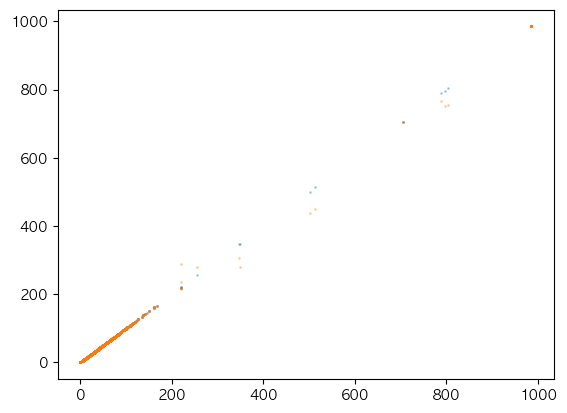

In [103]:
plt.scatter(predict_df['초미세먼지'],predict_df['lr'],s=1,alpha=0.3)
plt.scatter(predict_df['초미세먼지'],predict_df['rf'],s=1,alpha=0.3)

# 통계 (40점)

## 통계1

### 통계1-1      
어느 지역의 미세 지진 발생 간격은 평균 10년이다. 이 지진 발생 간격은 지수 분포를 따른다고 가정한다.      
최근 지진 이후 5년이 지난 시점에서 7년 이내에 지진이 발생하지 않을 확률은?     

In [104]:
from scipy.stats import expon
rv =expon(scale=10)

1- rv.cdf(7)

0.4965853037914095

### 통계 1-2
지난 지진 발생 후 15년이 지났다. 8년 이내에 지진이 발생할 확률은?

In [105]:
rv.cdf(8)

0.5506710358827784

## 통계2
data_path = './data/s1.csv'     
데이터는 식단과 운동강도에 따라 감량 체중을 기록한 다이어트 프로그램 결과이다. 

In [107]:
import pandas as pd
df =pd.read_csv('./data/s1.csv')
df.head()

,유저,식단,운동,감량체중
0,ID-1,저탄고단,저강도,5.496714
1,ID-2,저탄고단,저강도,4.861736
2,ID-3,저탄고단,저강도,5.647689
3,ID-4,저탄고단,저강도,6.523030
4,ID-5,저탄고단,저강도,4.765847


### 통계 2-1
식단과 운동의 조합으로 만들어지는 4개의 그룹들의 각 그룹의 정규성과 그룹간 등분산성을 확인하라    

In [108]:
from scipy.stats import shapiro , levene

df1 = df[(df.식단 =='저탄고단') &  (df.운동 =='저강도')]['감량체중']
df2 =df[(df.식단 !='저탄고단') &  (df.운동 =='저강도')]['감량체중']
df3 = df[(df.식단 =='저탄고단') &  (df.운동 !='저강도')]['감량체중']
df4 = df[(df.식단 !='저탄고단') &  (df.운동 !='저강도')]['감량체중']
print("저탄고단, 저강도:", shapiro(df1))
print("저탄고지, 저강도:", shapiro(df2))
print("저탄고단, 고강도 :", shapiro(df3))
print("저탄고지, 고강도:", shapiro(df4))

print(levene(df1,df2,df3,df4))

# 귀무가설 : 등분산 만족 / 정규성만족

저탄고단, 저강도: ShapiroResult(statistic=0.9792147874832153, pvalue=0.6603964567184448)
저탄고지, 저강도: ShapiroResult(statistic=0.968690812587738, pvalue=0.32686781883239746)
저탄고단, 고강도 : ShapiroResult(statistic=0.9704124927520752, pvalue=0.3708682358264923)
저탄고지, 고강도: ShapiroResult(statistic=0.9596078395843506, pvalue=0.16240304708480835)
LeveneResult(statistic=0.6668746759997108, pvalue=0.5736005994381859)


### 통계 2-2
이원분산분석을 진행하려한다. 2-1의 결과를 바탕으로 모수,비모수 방법을 결정하고 주효과에 대한 가설과 교호작용 효과에 대한 가설을 설정하라    

주효과 가설
- 식단에 대한 가설
    - 귀무 : 식단에 상관없이 감량체중의 값의 평균값이 동일하다.
    - 대립 : 적어도 하나의 식단 방식에서 감량체중의 값의 평균값이 다르다.
- 운동에 대한 가설
    - 귀무 : 운동에 상관없이 감량체중의 값의 평균값이 동일하다.
    - 대립 : 적어도 하나의 운동 방식에서 감량체중의 값의 평균값이 다르다.

교호작용 효과 가설
- 귀무 : 식단과 운동간의 교호작용 효과가 없다
- 대립 : 식단과 운동간의 교호작용 효과가 있다

### 통계2-3
통계검정을 실시하고 결과를 해석하라.    



In [110]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# 이원 분산 분석 수행
model = ols('감량체중 ~ C(식단) * C(운동)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA 결과:")
anova_table


ANOVA 결과:


,sum_sq,df,F,PR(>F)
C(식단),16.257434,1.0,18.352972,3.198226e-05
C(운동),70.040700,1.0,79.068753,1.401288e-15
C(식단):C(운동),0.714673,1.0,0.806792,3.704546e-01
Residual,138.187955,156.0,NaN,NaN


### 통계 2-4
사후검정을 실시하고 결과를 해석하라.

In [111]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['감량체중'], groups=df['식단'] + df['운동'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
저탄고단고강도,저탄고단저강도,-1.1896,0.0,-1.7361,-0.6431,True
저탄고단고강도,저탄고지고강도,-0.5039,0.0824,-1.0504,0.0427,False
저탄고단고강도,저탄고지저강도,-1.9608,0.0,-2.5073,-1.4142,True
저탄고단저강도,저탄고지고강도,0.6857,0.0074,0.1392,1.2323,True
저탄고단저강도,저탄고지저강도,-0.7712,0.0019,-1.3177,-0.2247,True
저탄고지고강도,저탄고지저강도,-1.4569,0.0,-2.0035,-0.9104,True


## 통계3
data_path = './data/s3.csv'     
나이와 성별, 급여 관련한 정보이다. 구매여부(Purchased)를 예측하는 로지스틱 회귀 모델을 만드려고 한다.

In [112]:
import pandas as pd
df =pd.read_csv('./data/s3.csv')
df

,Age,EstimatedSalary,Gender,Purchased
0,22,19000,0,0
1,25,20000,1,0
2,47,43000,0,1
3,52,46000,1,1
4,46,22000,1,0
5,56,80000,0,1
6,55,76000,0,1
7,60,83000,1,1
8,62,81000,1,1
9,61,89000,0,1


### 통계3-1
---
<모델학습조건>    
0,2,3,4의 인덱스 데이터를 테스트 데이터로 하고 나머지 행을 학습데이터로 한다.     
학습데이터에 Gender를 더미화하고 나이와 봉급은 표준화(Standardization) 하라.     
---
로지스틱 회귀 모델을 학습하고 모델 평가를 실시하여 결과를 출력하라. 훈련데이터와 평가데이터에 대한 각각의 accuracy 값을 출력하라.    

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


train = df.iloc[[1,5,6,7,8,9],:]
test = df.iloc[[0,2,3,4],:]

train_y = train['Purchased']
train_x = train.drop(columns =['Purchased'])
train_x['Gender'] = train_x['Gender'].astype('str')
train_x_dum =pd.get_dummies(train_x)


sc = StandardScaler()
sc_transform = sc.fit_transform(train_x_dum[['Age','EstimatedSalary']])

train_x_dum.iloc[:,:2] = sc_transform

lr = LogisticRegression()
lr.fit(train_x_dum,train_y)


test_y  =test['Purchased']
test_x = test.drop(columns =['Purchased'])
test_x['Gender'] = test_x['Gender'].astype('str')
test_x_dum =pd.get_dummies(test_x)

test_x_dum.iloc[:,:2] = sc.transform(test_x_dum[['Age','EstimatedSalary']])

from sklearn.metrics import accuracy_score
print('train accuracy  :',accuracy_score(train_y,lr.predict(train_x_dum)))
print('test accuracy  :',accuracy_score(test_y,lr.predict(test_x_dum)))



train accuracy  : 1.0
test accuracy  : 0.75


### 통계3-2
test데이터에 대해 예측하지 못한 레이블이 있다면 해당 데이터의 레이블 별 예측확률을 추출하라

In [114]:
lr.predict_proba(test_x_dum)[3]

array([0.44874249, 0.55125751])

### 통계 3-3
새로운 샘플 케이스가 들어왔고 해당 데이터의 더미화 및 표준화의 결과 후 값은 다음과 같다.
| Age  | EstimatedSalary | Gender_0 | Gender_1 |
|------|-----------------|--------|-----------|
| -0.6 | -1.8            | 0      | 1         |     


이 데이터에 대한 모델 결과를 예측하려한다.    
변수별 회귀 계수와 절편값을 통해 계산한 z값과 시그모이드 함수 출력 결과를 각각 구하여라

In [115]:
import numpy as np
x = np.array([-0.6, -1.8, 0,1])
z = np.dot(x,lr.coef_.T) + lr.intercept_
result = 1/(1+ np.exp(-z))

print(z,result)

[0.40038808] [0.5987809]


### 통계 3-4
3-1에서 학습한 모델의 각 변수들의 오즈비를 계산하여 출력하고 가장 많은 오즈가 증가하는 피쳐를 확인하라

In [116]:
cf = lr.coef_[0]
odds = np.exp(lr.coef_[0])
odds

# EstimatedSalary

array([2.01462508, 2.01894242, 1.17048971, 0.85429901])